# Import Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = 'Obfuscated-MalMem2022.csv'
df = pd.read_csv(file_path)
df['Category'] = df['Category'].str.extract(r'(-[^-\s]+|Benign)')

# Attempt ML with Categorical Labels
### Feature Engineering before modeling

In [2]:
#replace nan values with median
for col in df.columns:
    if df[col].dtype == np.number:
        df[col].fillna(df[col].median(), inplace=True)

C:\Users\shane\AppData\Local\Temp\ipykernel_33752\1219944723.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[col].dtype == np.number:


In [3]:
#drop duplicates
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows to be dropped: {num_duplicates}")
df = df.drop_duplicates()

Number of duplicate rows to be dropped: 549


In [4]:
#find columns without variation
zero_std_columns = [col for col in df.columns if df[col].dtype != object and df[col].std() == 0]
if len(zero_std_columns) > 0:
    print("Columns without variation:", ', '.join(zero_std_columns))
else:
    print("There are no columns without variation.")

Columns without variation: pslist.nprocs64bit, handles.nport, svcscan.interactive_process_services


In [5]:
#drop columns without variation
columns_to_drop = ['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services', 'Class']
df = df.drop(columns=columns_to_drop)

In [6]:
print("Class counts for 'Category':")
print(df['Category'].value_counts())

# print("\nClass counts for 'Class':")
# print(df['Class'].value_counts())

Class counts for 'Category':
Benign           29231
-Transponder      2409
-Shade            2127
-Ako              2000
-CWS              2000
-Scar             2000
-180solutions     1999
-Refroso          1996
-Gator            1994
-Conti            1987
-Emotet           1967
-Zeus             1949
-Maze             1754
-Pysa             1658
-Reconyc          1568
-TIBS             1408
Name: Category, dtype: int64


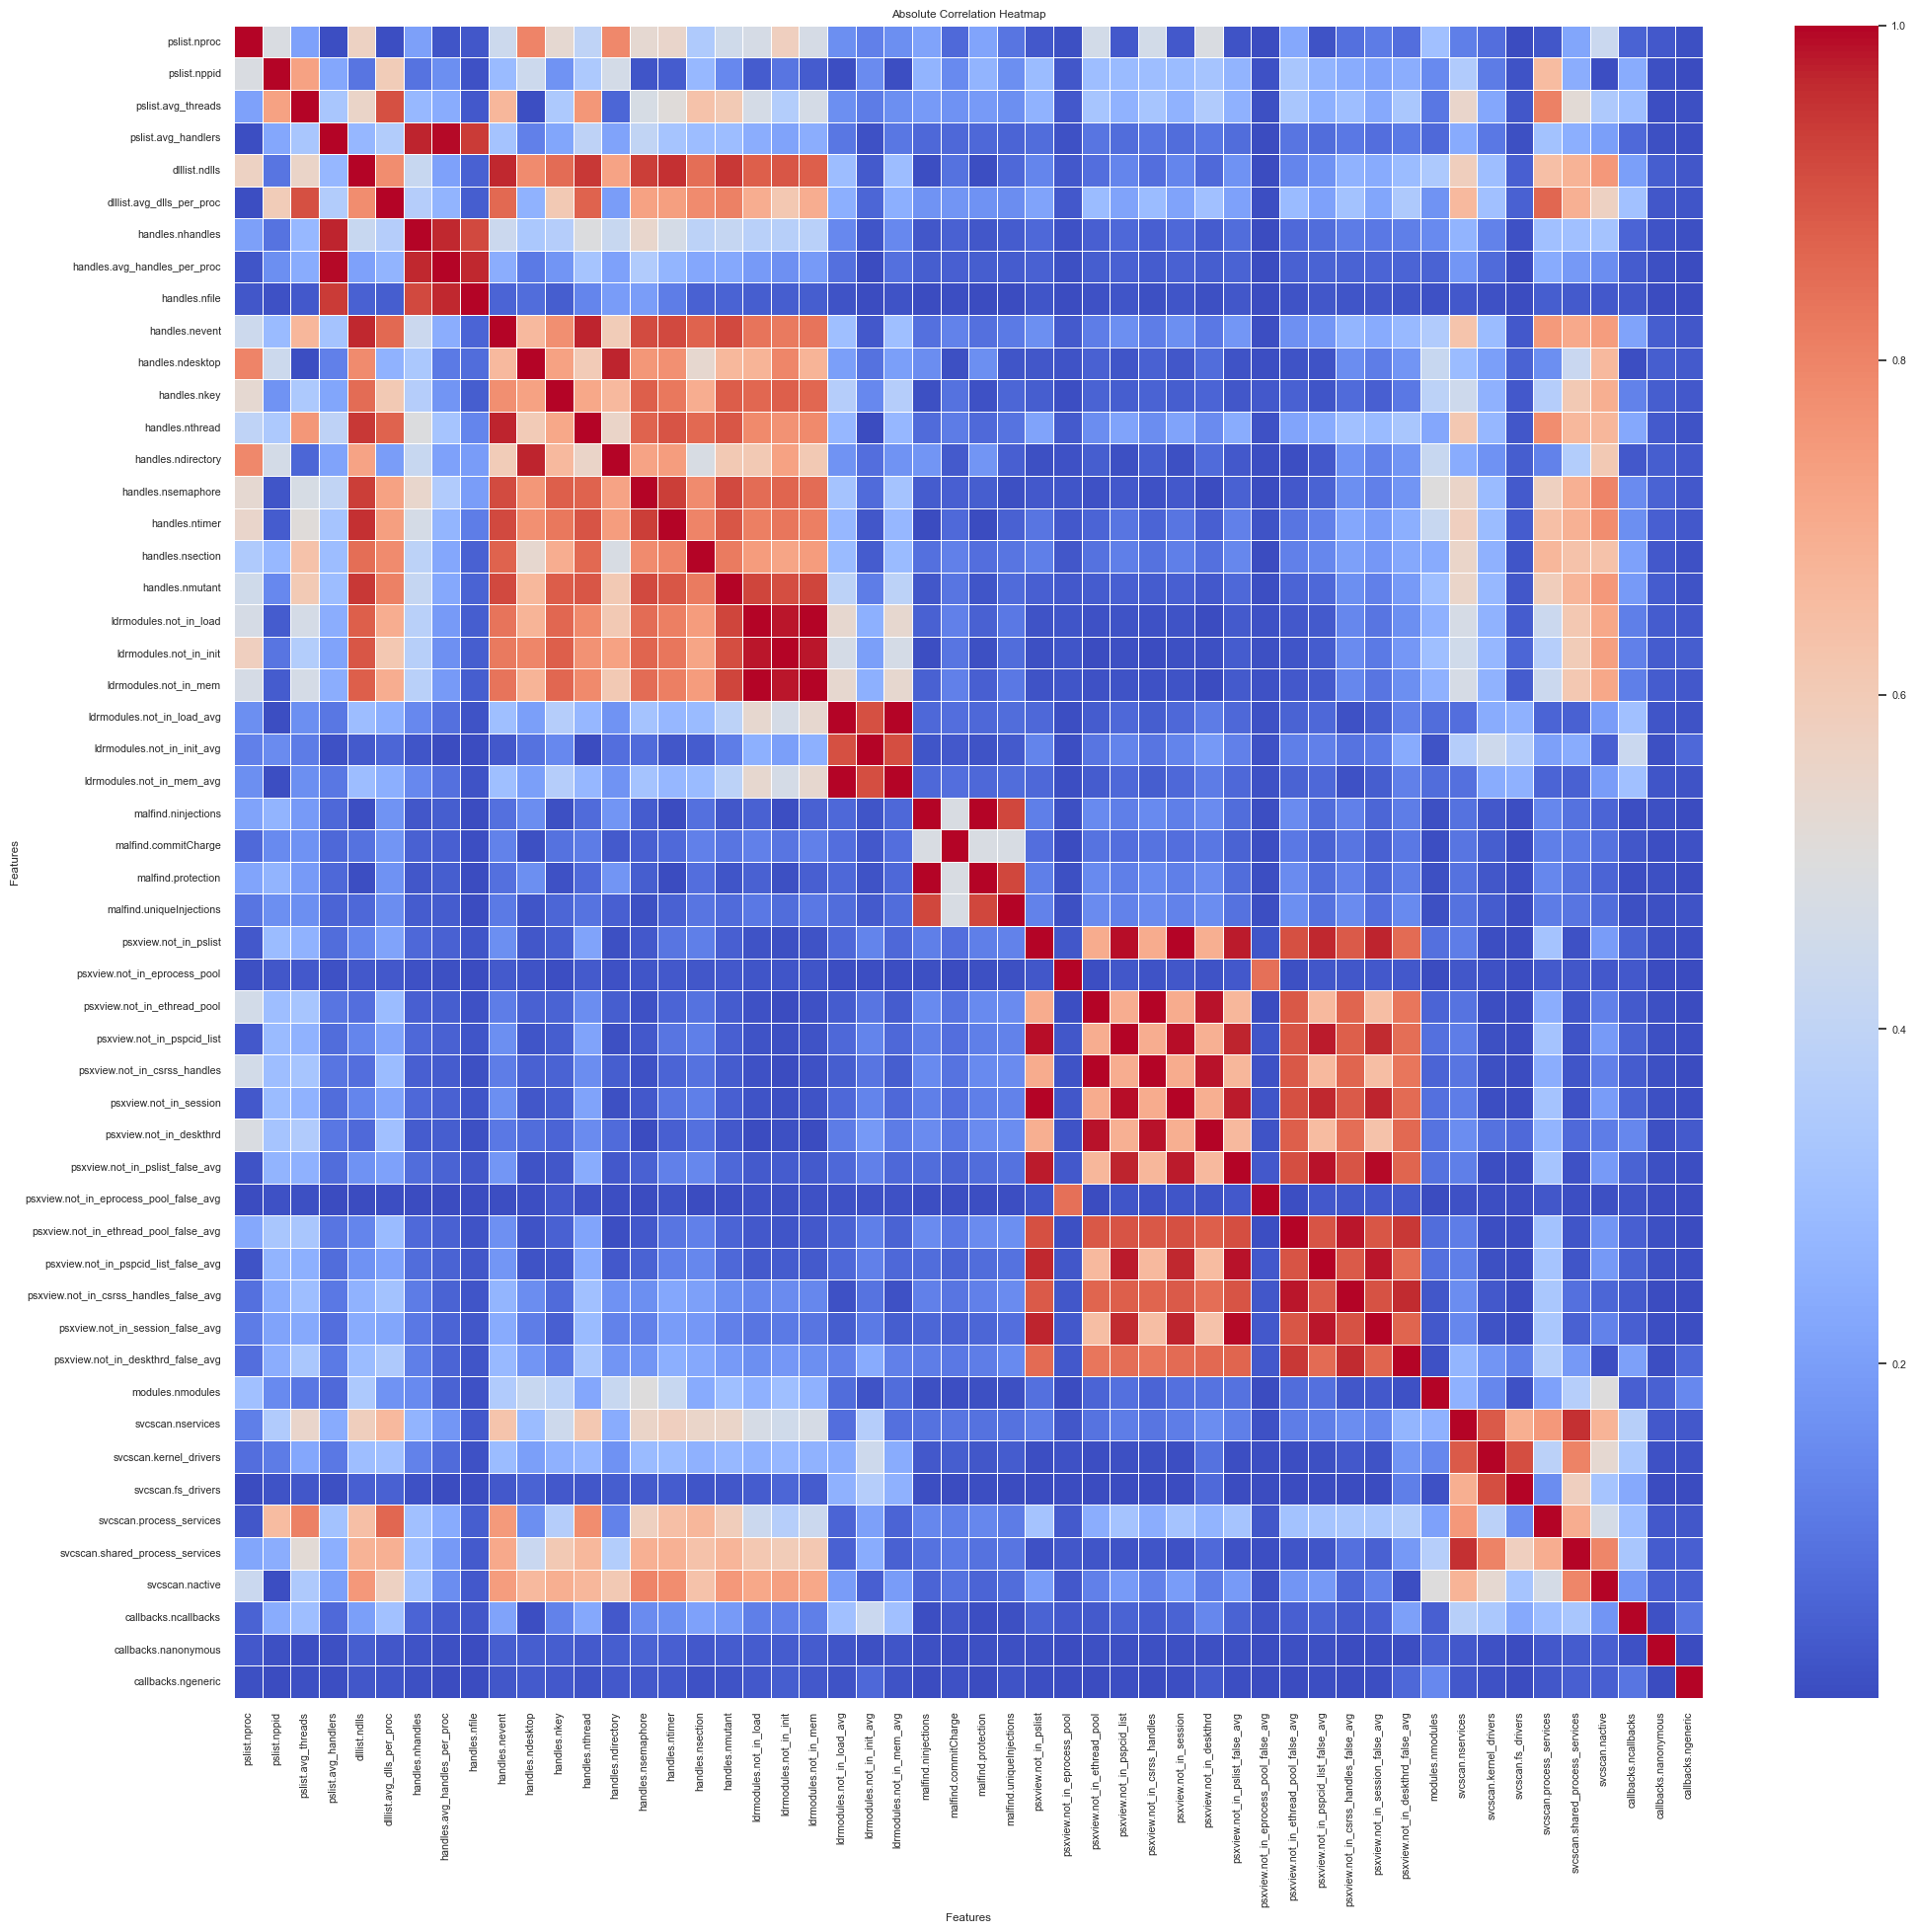

In [7]:
import seaborn as sns
import numpy as np

corr_matrix_abs = np.abs(df.corr())
plt.figure(figsize=(24, 22))
sns.set(font_scale=0.7)
sns.heatmap(corr_matrix_abs, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Absolute Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.savefig("absolute_correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
#print features with high correlation
high_corr = corr_matrix_abs[(corr_matrix_abs > 0.9) & (corr_matrix_abs < 1.0)]

print("Feature pairs with absolute correlation above 0.9:\n")
for i in high_corr.index:
    for j in high_corr.columns:
        if not np.isnan(high_corr.at[i, j]):
            print(f"{i} - {j}: {high_corr.at[i, j]}")

Feature pairs with absolute correlation above 0.9:

pslist.avg_threads - dlllist.avg_dlls_per_proc: 0.9049073963519746
pslist.avg_handlers - handles.nhandles: 0.971738547538218
pslist.avg_handlers - handles.avg_handles_per_proc: 0.9926160511317571
pslist.avg_handlers - handles.nfile: 0.9405348478909786
dlllist.ndlls - handles.nevent: 0.9662891570818908
dlllist.ndlls - handles.nthread: 0.9419790277643725
dlllist.ndlls - handles.nsemaphore: 0.9360222877462236
dlllist.ndlls - handles.ntimer: 0.9540690024358348
dlllist.ndlls - handles.nmutant: 0.941426997303879
dlllist.avg_dlls_per_proc - pslist.avg_threads: 0.9049073963519746
handles.nhandles - pslist.avg_handlers: 0.971738547538218
handles.nhandles - handles.avg_handles_per_proc: 0.9672008653762652
handles.nhandles - handles.nfile: 0.917226485867098
handles.avg_handles_per_proc - pslist.avg_handlers: 0.9926160511317571
handles.avg_handles_per_proc - handles.nhandles: 0.9672008653762652
handles.avg_handles_per_proc - handles.nfile: 0.9657

In [9]:
print(df.head())

  Category  pslist.nproc  pslist.nppid  pslist.avg_threads  \
0   Benign            45            17           10.555556   
1   Benign            47            19           11.531915   
2   Benign            40            14           14.725000   
3   Benign            32            13           13.500000   
4   Benign            42            16           11.452381   

   pslist.avg_handlers  dlllist.ndlls  dlllist.avg_dlls_per_proc  \
0           202.844444           1694                  38.500000   
1           242.234043           2074                  44.127660   
2           288.225000           1932                  48.300000   
3           264.281250           1445                  45.156250   
4           281.333333           2067                  49.214286   

   handles.nhandles  handles.avg_handles_per_proc  handles.nfile  ...  \
0              9129                    212.302326            670  ...   
1             11385                    242.234043            840  ...   

# Random Forest with Cross Validation

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer

#train/test split
X = df.drop(columns=['Category'])
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#encode target variable
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

#normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

f1_scorer = make_scorer(f1_score, average='weighted')

accuracy_scores = cross_val_score(clf, X_train_scaled, y_train_encoded, cv=5)
f1_scores = cross_val_score(clf, X_train_scaled, y_train_encoded, cv=5, scoring=f1_scorer)

print("Accuracy scores:", accuracy_scores)
print("Mean accuracy score:", np.mean(accuracy_scores))
print("F1 scores:", f1_scores)
print("Mean F1 score:", np.mean(f1_scores))

clf.fit(X_train_scaled, y_train_encoded)

y_pred_encoded = clf.predict(X_test_scaled)
y_pred = encoder.inverse_transform(y_pred_encoded)

report = classification_report(y_test_encoded, y_pred_encoded, output_dict=True)

class_names = encoder.classes_

for encoded_label, metrics in report.items():
    if encoded_label not in ["accuracy", "macro avg", "weighted avg"]:
        class_name = class_names[int(encoded_label)]
        print(f"{class_name}: {metrics['precision']}")

Accuracy scores: [0.74493971 0.74903101 0.75040379 0.74760418 0.74814256]
Mean accuracy score: 0.748024249580814
F1 scores: [0.74335406 0.74774248 0.74954127 0.74639195 0.74616972]
Mean F1 score: 0.7466398966908999
-180solutions: 0.43315508021390375
-Ako: 0.37305699481865284
-CWS: 0.4080604534005038
-Conti: 0.43532338308457713
-Emotet: 0.5072886297376094
-Gator: 0.5208747514910537
-Maze: 0.46645367412140576
-Pysa: 0.3784722222222222
-Reconyc: 0.5940298507462687
-Refroso: 0.7309523809523809
-Scar: 0.5330073349633252
-Shade: 0.4809843400447427
-TIBS: 0.7909407665505227
-Transponder: 0.42884990253411304
-Zeus: 0.4604651162790698
Benign: 1.0


### Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

clf = RandomForestClassifier(random_state=100)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

grid_search.fit(X_train, y_train_encoded)

print("Best hyperparameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best accuracy score: 0.7595236555002144


# Search through other models

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

models = [
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('Naive Bayes', GaussianNB())
]

for model_name, model in models:
    print(f"Training {model_name}...")
    
    accuracy_scores = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5)
    f1_scores = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5, scoring=f1_scorer)

    print(f"{model_name} Accuracy scores:", accuracy_scores)
    print(f"{model_name} Mean accuracy score:", np.mean(accuracy_scores))
    print(f"{model_name} F1 scores:", f1_scores)
    print(f"{model_name} Mean F1 score:", np.mean(f1_scores))

    model.fit(X_train_scaled, y_train_encoded)

    y_pred_encoded = model.predict(X_test_scaled)
    y_pred = encoder.inverse_transform(y_pred_encoded)

    report = classification_report(y_test_encoded, y_pred_encoded, output_dict=True)

    class_names = encoder.classes_

    for encoded_label, metrics in report.items():
        if encoded_label not in ["accuracy", "macro avg", "weighted avg"]:
            class_name = class_names[int(encoded_label)]
            print(f"{model_name} {class_name}: {metrics['precision']}")
            
    print("\n")

Training KNN...
KNN Accuracy scores: [0.66451335 0.66128338 0.66264671 0.66081619 0.66060084]
KNN Mean accuracy score: 0.6619720943958876
KNN F1 scores: [0.66576782 0.66142539 0.66410324 0.66216889 0.66162002]
KNN Mean F1 score: 0.6630170710702273
KNN -180solutions: 0.21282798833819241
KNN -Ako: 0.19170984455958548
KNN -CWS: 0.22567287784679088
KNN -Conti: 0.24065420560747663
KNN -Emotet: 0.3413897280966767
KNN -Gator: 0.42829076620825146
KNN -Maze: 0.3312883435582822
KNN -Pysa: 0.28888888888888886
KNN -Reconyc: 0.39855072463768115
KNN -Refroso: 0.5579710144927537
KNN -Scar: 0.3384615384615385
KNN -Shade: 0.40236686390532544
KNN -TIBS: 0.6995515695067265
KNN -Transponder: 0.3549222797927461
KNN -Zeus: 0.4171974522292994
KNN Benign: 0.9993063984740767


Training Decision Tree...
Decision Tree Accuracy scores: [0.72394488 0.71974591 0.7250996  0.71982341 0.72025412]
Decision Tree Mean accuracy score: 0.7217735826255238
Decision Tree F1 scores: [0.72397029 0.71522598 0.72592269 0.71906355

# PCA (old code)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA



n_components = 2
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)

X_test_pca = pca.transform(X_test)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Explained variance ratio: [0.53501841 0.43823703]


In [13]:
from sklearn.metrics import classification_report

clf.fit(X_train_pca, y_train_encoded)

y_pred_encoded = clf.predict(X_test_pca)

y_pred = encoder.inverse_transform(y_pred_encoded)

report = classification_report(y_test, y_pred, output_dict=True)

for class_name, metrics in report.items():
    if class_name != "accuracy" and class_name != "macro avg" and class_name != "weighted avg":
        print(f"{class_name}: {metrics['precision']}")


-180solutions: 0.1864406779661017
-Ako: 0.16966580976863754
-CWS: 0.17994858611825193
-Conti: 0.11956521739130435
-Emotet: 0.16784869976359337
-Gator: 0.28210526315789475
-Maze: 0.21100917431192662
-Pysa: 0.19732441471571907
-Reconyc: 0.16119402985074627
-Refroso: 0.4117647058823529
-Scar: 0.17678100263852242
-Shade: 0.22972972972972974
-TIBS: 0.4734982332155477
-Transponder: 0.19591836734693877
-Zeus: 0.2696335078534031
Benign: 0.9832931450223906
